In [1]:
%load_ext autoreload
%autoreload 2    
%matplotlib inline

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import numpy as np
import glob
from PIL import Image, ExifTags

# pip install torchsummary
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from time import time
import pandas as pd
import random

import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from matplotlib.patches import Polygon, Rectangle
import pylab
pylab.rcParams['figure.figsize'] = (6,6)

# Own imports 
from config import * 
from utils import *
from data_loader import TacoDataset
from eval import *

# speed-up using multithreads
cv2.setUseOptimized(True);
cv2.setNumThreads(8);

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
img_size = 512

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(10, 10, 10, p=0.3),
    A.GaussNoise(p=0.5),
    #A.Normalize(), # If you want to visualize - comment this line 
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco',
                            label_fields=['labels'],
                            min_visibility=0.3, # min visibility of the original area in case of a crop
                           )
)

test_transform = A.Compose([
    A.Resize(img_size, img_size),
    #A.Normalize(),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco',
                            label_fields=['labels'],
                           )
)

In [32]:
BATCH_SIZE = 32

In [33]:
trainset = TacoDataset( 'train', transforms=train_transform, test_size=0.2) # test_transform for no augment
valset   = TacoDataset('val', transforms=test_transform, test_size=0.2)
testset  = TacoDataset('test', transforms=test_transform, test_size=0.2)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)

In [34]:
loss_function = nn.BCELoss()

model = models.resnet34(weights=models.ResNet34_Weights)
model = transfer_model_set(model, freeze_convs=True)
optimizer = torch.optim.Adam(model.parameters(), HEAD_LEARNING_RATE)

lr_scheduler = None

Freezing Convs


In [35]:
NUM_EPOCHS = 10

In [36]:
for epoch in range(NUM_EPOCHS):
    model.train()
    print(f"EPOCH {epoch}/{NUM_EPOCHS}")

    train_loss = []
    train_correct = 0
    train_len = 0
    
    for minibatch_no, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
        
        images = [image for image, _, _ in batch]
        bboxes = [bbox for _, bbox, _ in batch]
        labels = [label for _, _, label in batch]
        
        # Selective search
        
        cropped_images_all, proposals_all, predictions_all = selective_search_train(images, bboxes)            
        data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)
        
        # CNN
        optimizer.zero_grad()
        output = model(data)[:,0]
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        predicted = output > 0.5
        train_correct += (target==predicted).sum().cpu().item()
        train_len += data.shape[0]
        print(f'train_loss: {loss:.5f}')
        # break
        
    # Test evaluation
    model.eval()
    for batch in val_loader:
        test_images = [image for image, _, _ in batch]
        test_bboxes = [bbox for _, bbox, _ in batch]
        test_labels = [label for _, _, label in batch]
        
        # Selective search
        test_cropped_images_all, test_proposals_all = selective_search_test(test_images, test_bboxes) 
        test_data = torch.stack(test_cropped_images_all).to(device)
        
        with torch.no_grad():
            outputs = model(test_data)[:,0]
        predicted = (outputs > 0.5).tolist()
        
        # Reshaping
        outputs = outputs.tolist()
        new_shape = [len(l) for l in test_proposals_all]
        output_new_shape, predicted_new_shape = [], []
        head = 0
        for l in new_shape:
            output_new_shape.append(outputs[head:l+head])
            predicted_new_shape.append(predicted[head:l+head])
            head += l

        # Filitering classes from background
        predicted_bboxes = list(compress(test_proposals_all, predicted_new_shape))
        output_new_shape = list(compress(output_new_shape, predicted_new_shape))
        
        pred = [dict(
            boxes=torch.FloatTensor(bboxes),
            scores=torch.FloatTensor(output),
            labels=torch.ones(len(output)) # Simplification for Binary
        ) for bboxes, output in zip(predicted_bboxes, output_new_shape)]
        
        target = [dict(
            boxes=torch.FloatTensor(bboxes),
            labels=torch.FloatTensor(label)
        ) for bboxes, label in zip(test_bboxes, test_labels)]
        
        # Computing mAP
        metric = MeanAveragePrecision()
        metric.update(pred, target)
        maps = metric.compute()
        print(f'MAP: {float(maps["map"].detach().cpu()):.3f}          MAP@50: {float(maps["map_50"].detach().cpu()):.3f}          MAP_small: {float(maps["map_small"].detach().cpu()):.3f}          MAP_large: {float(maps["map_large"].detach().cpu()):.3f}')
        

EPOCH 0/10


  0%|          | 0/29 [00:00<?, ?it/s]

/zhome/8d/e/198218/dlincv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


KeyboardInterrupt: 

In [56]:

images = [image for image, _, _ in batch]
bboxes = [bbox for _, bbox, _ in batch]
labels = [label for _, _, label in batch]


In [50]:
image, bboxes, labels = trainset.__getitem__(100)

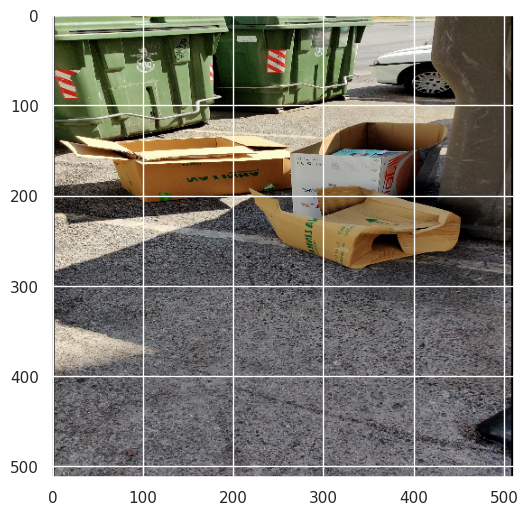

In [70]:
plt.imshow(images[1].detach().permute(1,2,0).cpu().numpy())

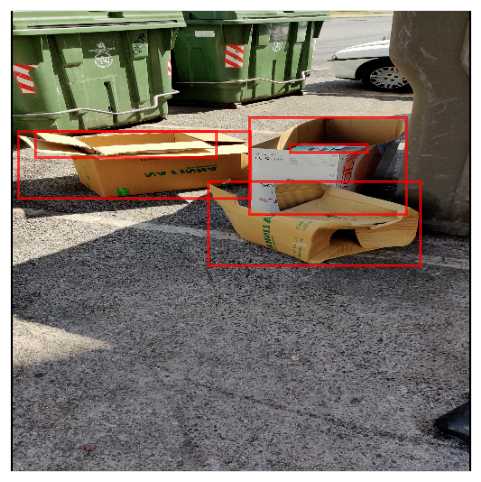

In [83]:
fig,ax = plt.subplots(1)

plt.imshow(images[1].permute(1,2,0))
plt.xticks([])
plt.yticks([])

# Show annotations
for ann in bboxes[1]:
    [x, y, x1, y1] = ann
    rect = Rectangle((x,y),x1-x,y1-y,linewidth=2,edgecolor='red',
                     facecolor='none', alpha=0.7)
    ax.add_patch(rect)
#plt.savefig(f'imgs/output_{img_idx}.png')
plt.show()

In [84]:

# Selective search
cropped_images_all, proposals_all, predictions_all = selective_search_train([images[1]], [bboxes[1]])            
data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)


/tmp/ipykernel_1458/2350360117.py:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)


In [113]:
len(cropped_images_all)

9

In [112]:
data.shape

torch.Size([9, 3, 300, 300])

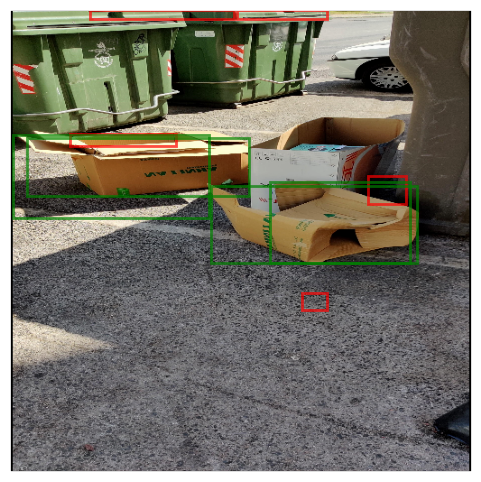

In [93]:
fig,ax = plt.subplots(1)

plt.imshow(images[1].permute(1,2,0))
plt.xticks([])
plt.yticks([])

# Show annotations
for i, ann in enumerate(proposals_all[0]):
    
    [x, y, x1, y1] = ann
    if predictions_all[i]:
        edge_col = 'green'
    else:
        edge_col = 'red'
    rect = Rectangle((x,y),x1-x,y1-y,linewidth=2,edgecolor=edge_col,
                     facecolor='none', alpha=0.7)
    ax.add_patch(rect)
#plt.savefig(f'imgs/output_{img_idx}.png')
plt.show()

In [104]:
predictions_all

[False, False, False, True, True, True, True, False, False]

In [105]:
target

tensor([0., 0., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0')

In [97]:
predictions_all

[False, False, False, True, True, True, True, False, False]

In [96]:
target

tensor([0., 0., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0')

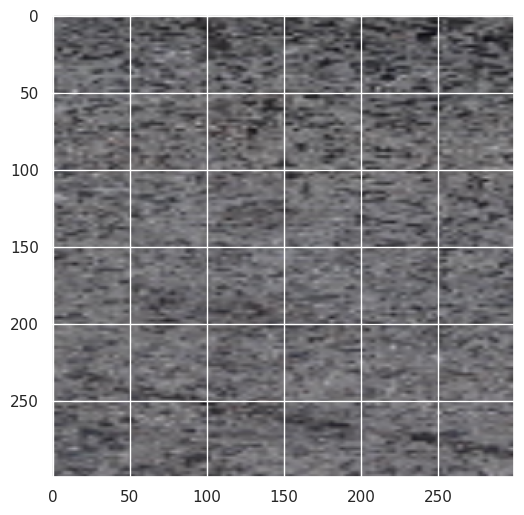

In [110]:
plt.imshow(data[3].detach().permute(1,2,0).cpu().numpy())

In [ ]:

# CNN
optimizer.zero_grad()
output = model(data)[:,0]
loss = loss_function(output, target)
loss.backward()
optimizer.step()

train_loss.append(loss.item())
predicted = output > 0.5
train_correct += (target==predicted).sum().cpu().item()
train_len += data.shape[0]
print(f'train_loss: {loss:.5f}')
# break
        